## First import the zip file and dezip it 

https://www.kaggle.com/datasets/aslanahmedov/number-plate-detection

### reprise de la correction pour ce challenge fait en dernier car chess a pris du temps

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import shutil
from bs4 import BeautifulSoup
from tqdm.contrib.concurrent import process_map
import multiprocessing
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# 1- Data processing

#### 1.1 Count the number of files in image directory and determine their file types.

In [ ]:
#img_directory = "/content/number_plate/images"
img_directory = "/content/images"
list_files = glob.glob(img_directory + "/*")
print(f"Il y a {len(list_files)} fichiers dans le dossier images")
print("-----------------------------------------------------------")
print(f"Exemple de filepath dans le dossier : {sorted(list_files)[:4]}")

#### 1.2 Count the number of xml files and jpeg files

In [ ]:
list_extension = list(set([elt.split('.')[1]for elt in os.listdir(img_directory)]))
print(f"Voici les extensions existantes : {list_extension}")
print("---------------------------------------")
#Nombre de fichiers avec chacune des extensions 
print("Nombre de fichiers xml :", len(glob.glob(img_directory + "/*.xml")))
print("---------------------------------------")
print("Nombre de fichiers jpeg :", len(glob.glob(img_directory + "/*.jpeg")))

#### You may now notice that there are more images than associated XML files. What are these images? Delete them from the "image" directory.

#### We can now see that we have one XML file per image. In each file, we have the file path of the image, the name of the object to be detected, the width and height of the image, and the coordinates (in the format xmin, xmax, ymin, ymax) of the bounding box that surrounds the license plat

####  We will now read the XML files and store the information in a dataframe. We want to create a dataframe that contains the file path of the image, the object to be detected, the image shape, and the bounding box of the object. There are many options available to parse an XML file, but we recommend using Beautiful Soup, which you have already seen earlier in your journey.

#### 1.3 Create a dataframe with 8 columns (and number of lines = number of images).  
The columns are :  

1.   filepath_img
2.   name_object
3.   height_img
4.   width_img
5.   xmin
6.   xmax
7.   ymin
8.   ymax


In [ ]:
### tjs le correctif

# on cree notre fonction permettant de parser nos xml
def parse_xml(filepath):

  with open(filepath,'r') as f:
    file = f.read()
  
  soup = BeautifulSoup(file,'xml')

  filepath_img = soup.find('path').text
  name_object = soup.find('name').text
  height_img = int(soup.find('height').text)
  width_img = int(soup.find('width').text)
  depth_img = int(soup.find('depth').text)
  xmin = int(soup.find('xmin').text)
  xmax = int(soup.find('xmax').text)
  ymin = int(soup.find('ymin').text)
  ymax = int(soup.find('ymax').text)

  return filepath_img,name_object,height_img,width_img,depth_img,xmin,xmax,ymin,ymax

#on cree un dictionnaire pour stocker les valeurs
result_dict = {
              'filepath_img': [],
              'name_object': [],
              'height_img': [],
              'width_img' : [],
              'depth_img' : [],
              'xmin': [],
              'xmax': [],
              'ymin': [],
              'ymax': []
               }
#on itere sur nos xml pour les parser en utilisant les differents cpu
for elt in process_map(parse_xml,glob.glob(img_directory + "/*.xml"),max_workers = multiprocessing.cpu_count()):

  result_dict['filepath_img'].append(elt[0])
  result_dict['name_object'].append(elt[1])
  result_dict['height_img'].append(elt[2])
  result_dict['width_img'].append(elt[3])
  result_dict['depth_img'].append(elt[4])
  result_dict['xmin'].append(elt[5])
  result_dict['xmax'].append(elt[6])
  result_dict['ymin'].append(elt[7])
  result_dict['ymax'].append(elt[8])

print('Done create dictionnary')

print("Creating DataFrame")
df = pd.DataFrame(result_dict)

print("Done Creating DataFrame")

#la base du filepath_img n'est pas le bon donc on le modifie

df["filepath_img"]  = df["filepath_img"].apply(lambda x : "/content/images/" + x.split('/')[-1])


df.head(10)

#### 1.4 We will create 4 differents target variables:

1. Xmoy, which represents the x-coordinate of the center of the bounding box.
2. Ymoy, which represents the y-coordinate of the center of the bounding box.
3. W, the width of the bounding box.
4. H, the height of the bounding box.

Furthermore, we will normalize these values with respect to the image shape.

Later on, we can delete the "name_object" column since there is only one object to be detected per image and the xmin, xmax, ymin, ymax columns.




1.   Create the features xmoy,ymoy,w,h
2.   Normalize this features by the height and width of the image
3. drop xmin,xmax,ymin,ymax in the dataframe


In [ ]:
from IPython.display import Image
Image(filename='/content/object_detection_coord_min_max.png')

In [ ]:
df["w"] = (df["xmax"] - df["xmin"])/ df["width_img"]
df["h"] = (df["ymax"] - df["ymin"]) / df["height_img"]
df["xmoy"] = (df["xmax"] + df["xmin"])/(2 * df["width_img"])
df["ymoy"] = (df["ymax"] + df["ymin"])/(2 * df["height_img"])

df = df.drop(['xmin','xmax','ymin','ymax','name_object'],axis = 1)

# 2- Data analysis

##### 2.1 Analyze the size of the images. Do we have images of small or large size?

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(121)
sns.histplot(df["height_img"],bins = 20)
plt.title("Répartition de la hauteur des images")
plt.subplot(122)
sns.histplot(df["width_img"],bins = 20)
plt.title("Répartition de la largeur des images")

##### 2.2 Now Analyze the size of the bbox. where are the plate in the image ? the objet are small or large ?

##### Use the function show_bounding_box to plot some images with their bbox

In [12]:
#fonction a donner aux étudiants
def show_bounding_box(im, bbox, normalised=True, color='r'):
    # Signification de bbox
    x, y, w, h = bbox
    # Convertir les cordonées (x,y,w,h) en (x1,x2,y1,y2)
    x1=x-w/2
    x2=x+w/2
    y1=y-h/2
    y2=y+h/2
    
    # Redimentionner en cas de normalisation
    if normalised:
        x1=x1*im.shape[1]
        x2=x2*im.shape[1]
        y1=y1*im.shape[0]
        y2=y2*im.shape[0]
        
    # Afficher l'image
    plt.imshow(im)
    
    # Afficher la bounding box
    plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],"r")

# Data modeling

#### In this section, we will use pre-trained Yolov5 model to predict the coordinates of the bbox 
And after we apply a OCR model to detect what is the text on the bbox

In [14]:
#Apply this code
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15589, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 15589 (delta 85), reused 103 (delta 46), pack-reused 15393
Receiving objects: 100% (15589/15589), 14.63 MiB | 28.76 MiB/s, done.
Resolving deltas: 100% (10613/10613), done.


In [15]:
#and this
!pip install -r ./yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


#### we are going to create 1folder and 2 subfolder


1.   *data_images* folder
2.   in the *data_images* folder we create **data_train** and **data_test**



In [16]:
!mkdir yolov5/data_images/
!mkdir yolov5/data_images/test/
!mkdir yolov5/data_images/train/

#### split the data on train/test (200 first lines train and the other test)
call df_train and df_test

In [17]:
df_train = df.iloc[:200]
df_test = df.iloc[200:]

#### Compile this code and understand what it does.

In [18]:
from shutil import copy
import os
train_folder = './yolov5/data_images/train'

values = df_train[['filepath_img','xmoy','ymoy','w','h']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = './yolov5/data_images/test'

values = df_test[['filepath_img','xmoy','ymoy','w','h']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

#### now we apply the yolov5 model on 100 epochs (not forget to active gpu)

In [19]:
!python ./yolov5/train.py --data ./data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=./data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-153-gff6a9ac Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, c

#### we save and import the weights of the model

In [27]:
import cv2
!pip install onnx onnxruntime
!pip install opencv-python-headless

!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

net = cv2.dnn.readNetFromONNX('/content/yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-153-gff6a9ac Python-3.9.16 torch-2.0.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 2.0.0+cu118...
TorchScript: export success ✅ 2.8s, saved as yolov5/runs/train/Model/weights/be

#### Compute the code below 

In [28]:
import numpy as np

INPUT_WIDTH =  640
INPUT_HEIGHT = 640

def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.01:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image


def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return 'no number'
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text

def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

#### Compute the code below to install tesseract ocr

In [29]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Read the image test and apply yolo_prediction with the weights of the model 

####Plot the result and we finish the project congrats !! 

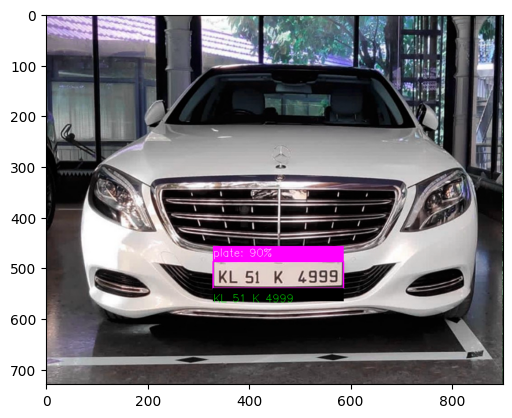

In [30]:
import pytesseract as pt
import matplotlib.pyplot as plt

#read image test

img = cv2.imread('/content/TEST/TEST.jpeg')
results = yolo_predictions(img,net)

plt.imshow(results)